# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.
import numpy as np


# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:]

# TODO: how many classes are in the dataset
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

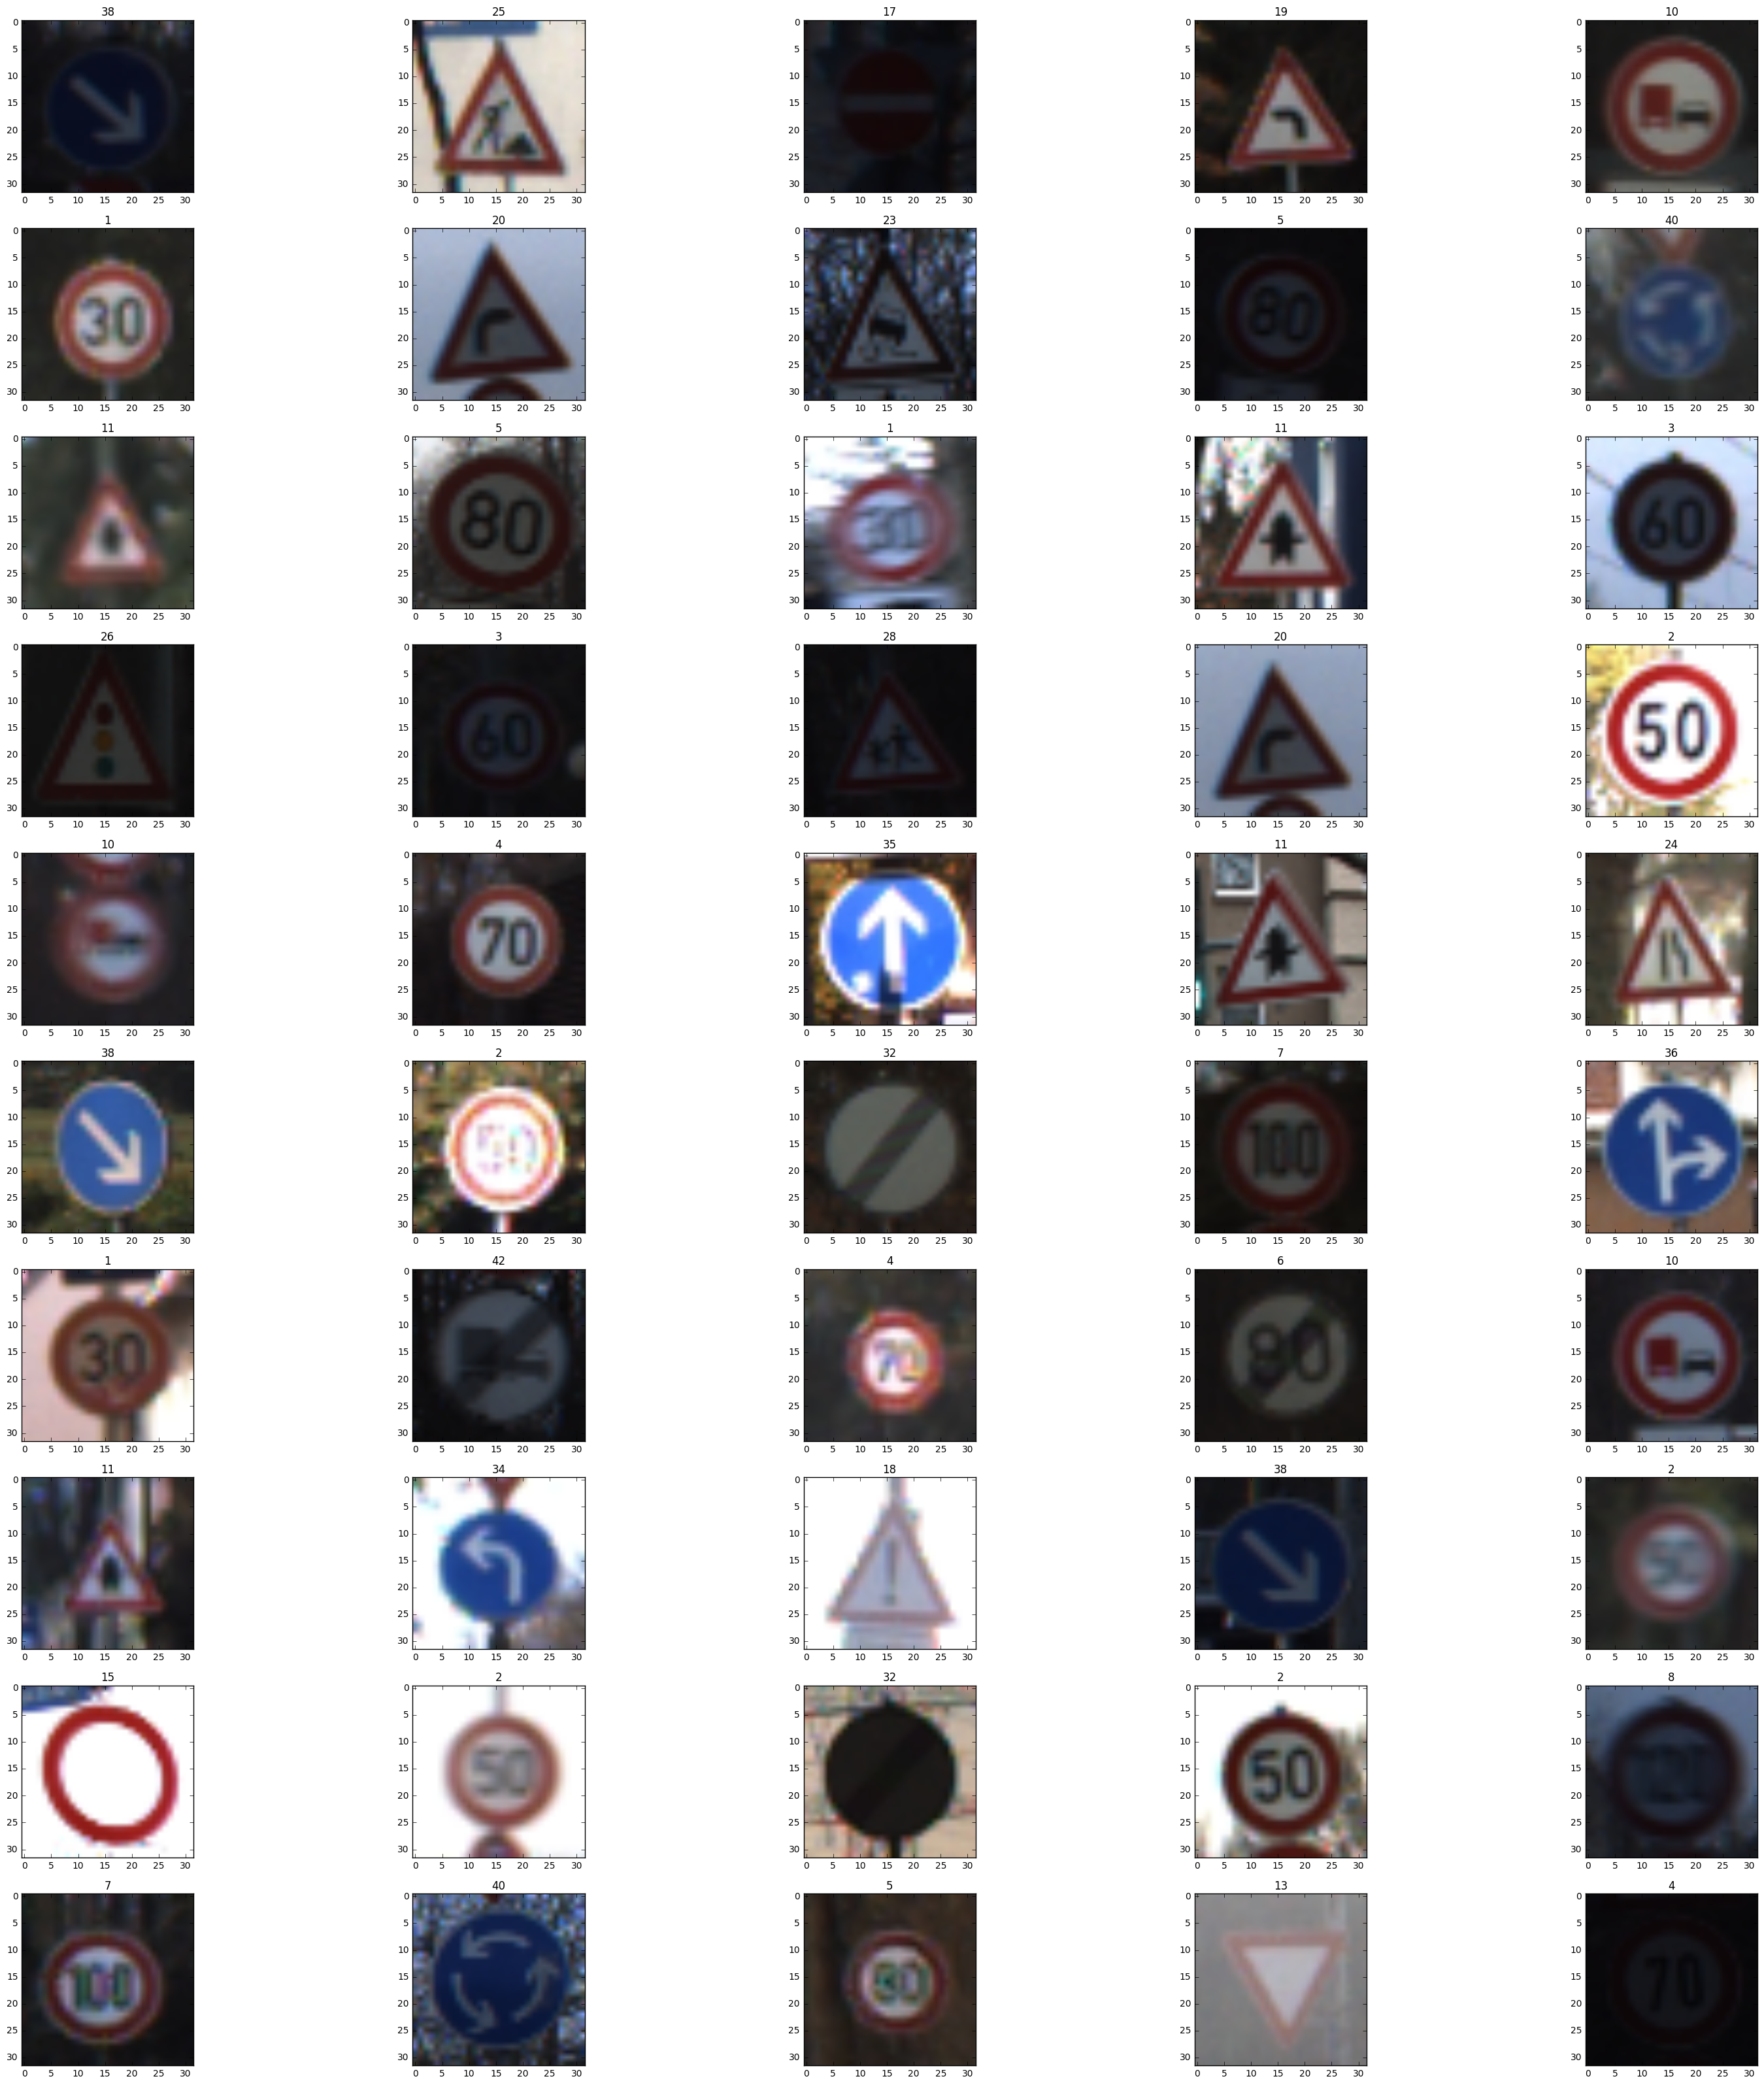

In [4]:
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import random as rnd

def plotImagesFromSet(img_set, labels):
    num_samples = 50

    n_row, n_col = 10, 5
    fig = plt.figure(figsize=(32,32))
    n_imgs = len(img_set)
    for plt_idx in range(num_samples):
        idx = rnd.randint(0, n_imgs)
        img = img_set[idx]

        splt = plt.subplot(n_row,n_col, plt_idx + 1)
        splt.set_title("{}".format(labels[idx]))
        plt.imshow(img, cmap='Greys_r')

    plt.tight_layout()
    plt.show()
plotImagesFromSet(X_train, y_train)

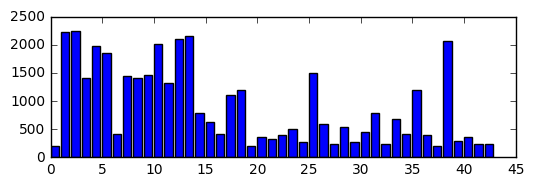

In [5]:
# how many samples of each class are in data sets
train_cnt = np.bincount(y_train)
#print(train_cnt)

train_plt = plt.subplot(211)
train_plt.bar(range(train_cnt.shape[0]), train_cnt)
plt.show()

In [6]:
def plotLabelDistribution(labels, title=""):
    tst_cnt = np.bincount(labels)

    tst_plt = plt.subplot(211)
    tst_plt.bar(range(tst_cnt.shape[0]), tst_cnt)
    tst_plt.set_title(title)
    plt.show()

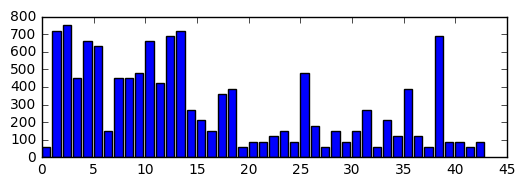

In [7]:
plotLabelDistribution(y_test)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [9]:
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedShuffleSplit

In [10]:
# combine data for future shuffling and modification
X_data = np.concatenate([X_train, X_test])
y_data = np.concatenate([y_train, y_test])
print("Combined data: x={}, y={}".format(X_data.shape, y_data.shape))

Combined data: x=(51839, 32, 32, 3), y=(51839,)


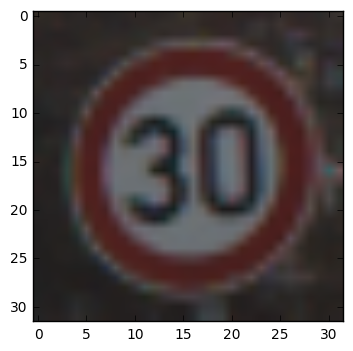

In [11]:
img = X_data[rnd.randint(0, X_data.shape[0])]
plt.imshow(img)
plt.show()


In [12]:

def convToGrey(imArray):
    outArray = []
    for img in imArray:
        outArray.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return np.array(outArray)
        
X_data_g = convToGrey(X_data)


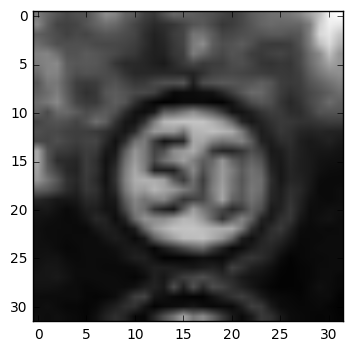

In [13]:
img2 = X_data_g[rnd.randint(0, X_data_g.shape[0])]
plt.imshow(img2, cmap='Greys_r')
plt.show()

### Add more data

In [14]:
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [15]:
X_data_g = np.reshape(X_data_g, (-1, 32, 32, 1))

In [16]:
"""class_count = np.bincount(y_data)

num_target = 50000
new_data = []
new_classes = []
for cl in range(1):
    cnt = class_count[cl]
    runs = num_target - cnt
    
    idx_cl = y_data == cl
    X_cl = X_data_g[idx_cl]
    for r in range(runs):
        img = X_cl[rnd.randint(0, len(X_cl) - 1)]
        img = transform_image(img, 30, 10, 25)
        new_data.append(img)
        new_classes.append(cl)
        

new_data = np.array(new_data)
new_classes = np.array(new_classes)
plotImagesFromSet(new_data, new_classes)"""

'class_count = np.bincount(y_data)\n\nnum_target = 50000\nnew_data = []\nnew_classes = []\nfor cl in range(1):\n    cnt = class_count[cl]\n    runs = num_target - cnt\n    \n    idx_cl = y_data == cl\n    X_cl = X_data_g[idx_cl]\n    for r in range(runs):\n        img = X_cl[rnd.randint(0, len(X_cl) - 1)]\n        img = transform_image(img, 30, 10, 25)\n        new_data.append(img)\n        new_classes.append(cl)\n        \n\nnew_data = np.array(new_data)\nnew_classes = np.array(new_classes)\nplotImagesFromSet(new_data, new_classes)'

In [17]:
# Normalize input data
def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    pixel_depth = 255.0
#     result = np.zeros_like(image_data, dtype=np.float)
    
    a = 0.1
    b = 0.9
#     for i in range(len(image_data)):
#         px = image_data[i]
#         px = a + (px / 255.0) * (b - a) 
#         result[i] = px

#     return a + (image_data / 255.0) * (b - a)
    return (image_data - pixel_depth / 2) / pixel_depth

#X_train_norm = normalize_greyscale(X_train)

# a = 0.1
# b = 0.9
# X_train = a + (X_train / 255.0) * (b - a)
    

In [18]:
X_data_norm = normalize_greyscale(X_data_g)

Suffled shapes: train=(44063,); test=(7776,)
Suffled shapes 2: train=(39656, 32, 32, 1); test=(7776, 32, 32, 1); valid=(4407, 32, 32, 1)


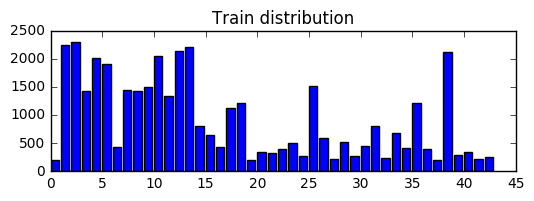

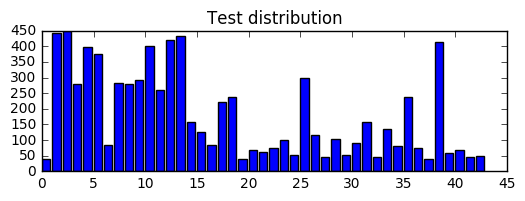

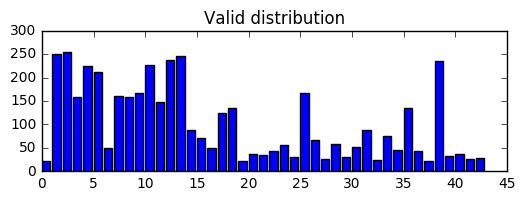

In [19]:
# Let's do suffle split
splitter = StratifiedShuffleSplit(test_size=0.15, n_splits=1)
sp = splitter.split(X_data_norm, y_data)
# print(sp)
idx_train, idx_test = next(sp)

X_train_shuffled, X_test_shuffled = X_data_norm[idx_train], X_data_norm[idx_test]
y_train_shuffled, y_test_shuffled = y_data[idx_train], y_data[idx_test]
print("Suffled shapes: train={}; test={}".format(y_train_shuffled.shape, y_test_shuffled.shape))

# now split validation from train set
splitter = StratifiedShuffleSplit(test_size=0.1, n_splits=1)
idx_train, idx_valid = next(splitter.split(X_train_shuffled, y_train_shuffled))
X_train_shuffled_1, X_valid_shuffled = X_train_shuffled[idx_train], X_train_shuffled[idx_valid]
y_train_shuffled_1, y_valid_shuffled = y_train_shuffled[idx_train], y_train_shuffled[idx_valid]

X_train_shuffled = X_train_shuffled_1
y_train_shuffled = y_train_shuffled_1

print("Suffled shapes 2: train={}; test={}; valid={}".format(X_train_shuffled.shape, X_test_shuffled.shape, X_valid_shuffled.shape))

plotLabelDistribution(y_train_shuffled, "Train distribution")
plotLabelDistribution(y_test_shuffled, "Test distribution")
plotLabelDistribution(y_valid_shuffled, "Valid distribution")

#convert y to one-hot

y_train_shuffled = (np.arange(n_classes) == y_train_shuffled[:,None]).astype(np.float32)
y_test_shuffled =  (np.arange(n_classes) == y_test_shuffled[:,None]).astype(np.float32)
y_valid_shuffled =  (np.arange(n_classes) == y_valid_shuffled[:,None]).astype(np.float32)

In [55]:
#plotImagesFromSet(np.reshape(X_valid_shuffled, (-1, 32, 32)), y_valid_shuffled)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
1. Shuffling: reshuffled all data after combining data sets
2. Color transformations: converted all images to greyscale for simplicity as other researches shown very good results with simple greyscale images
3. Images normalized to [-0.5, 0.5] values

In [21]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
1. All data was reshuffled and split equally across the classes (every class has equal percentage of data)
2. Test is 20% from Total data set. Validation is 10% from Training data set (what left from splitting into train/test)

In [22]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [94]:

tSignsGraph = tf.Graph()

stdev = math.sqrt(1e-3)
L2C = 5e-5
DECAY_START = 0.1
DECAY_RATE = 0.95
DECAY_STEPS = 300

patch_size = 5
conv_stride = 1
num_channels = 1
depth = 32

# all layer sizes are defined in this variable for flexibility with graph configuration
# In Conv model classifier input size == image size reduced by convolution stride (for each convolution)
layerSize = [ [None, image_shape[0], image_shape[1], num_channels], #input
             [patch_size, patch_size, num_channels, depth], depth, #convolution
             [patch_size, patch_size, depth, depth], depth, #convolution
             image_shape[0] // 2 * image_shape[1] // 2 * depth, n_classes] #fully connected
#layerSize = [28 * 28, 10] #mnist test
print("Layer size: {}".format(layerSize))

with tSignsGraph.as_default():
    gInputs = tf.placeholder(tf.float32, shape=layerSize[0], name="inputs")
    gLabels = tf.placeholder(tf.float32, shape=(None, layerSize[-1]), name="labels")
    gKeepProb = tf.placeholder_with_default(1.0, None)
    
    layer1_weights = tf.Variable(tf.truncated_normal( shape=layerSize[1], stddev=stdev) )
    layer1_biases = tf.Variable(tf.zeros([layerSize[2]]))
    
    layer2_weights = tf.Variable(tf.truncated_normal( shape=layerSize[3], stddev=stdev) )
    layer2_biases = tf.Variable(tf.zeros([layerSize[4]]))
    
#     gHWeights = tf.Variable(tf.truncated_normal((layerSize[-3], layerSize[-2]), stddev=stdev))
#     gHBiases = tf.Variable(tf.zeros((layerSize[-2])))
    
    #fully connected layer
    gFWeights = tf.Variable(tf.truncated_normal((layerSize[-2], layerSize[-1]), stddev=stdev))
    gFBiases = tf.Variable(tf.zeros((layerSize[-1])))
    
    gWeights = [gFWeights] 
    
    def model(inputD):
        #print("Model shapes: {}, weights: {}".format(inputD.get_shape().as_list(), layer1_weights.get_shape().as_list()))
        conv = tf.nn.conv2d(inputD, layer1_weights, [1, conv_stride, conv_stride, 1], padding='SAME')
        conv = tf.nn.relu(conv + layer1_biases)
    
        conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
    
        conv = tf.nn.conv2d(conv, layer2_weights, [1, conv_stride, conv_stride, 1], padding='SAME')
        conv = tf.nn.relu(conv + layer2_biases)
        
        shape = conv.get_shape().as_list()
#         print('Shape {}'.format(shape))
        convTransf = tf.reshape(conv, [-1, shape[1] * shape[2] * shape[3]])
        drop = tf.nn.dropout(convTransf, keep_prob=gKeepProb)
#         hidden = tf.matmul(inputD, gHWeights) + gHBiases
#         hidden = tf.nn.relu(hidden)

        fcon = tf.matmul(drop, gFWeights) + gFBiases
        return fcon
    
    L2 = 0
    for w in gWeights:
        L2 += tf.nn.l2_loss(w)
    
    gLogits = model(gInputs)
    gCrossEntropy = tf.nn.softmax_cross_entropy_with_logits(gLogits, gLabels)
    gLoss = tf.reduce_mean(gCrossEntropy) + L2 * L2C
    
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(DECAY_START, global_step, DECAY_STEPS, DECAY_RATE, staircase=True)
    gOptimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(gLoss, global_step=global_step)#, global_step=global_step
    
    gPredictions = tf.nn.softmax(gLogits)
    gPredictionClass = tf.argmax(gPredictions, 1)
    gLabelClass = tf.argmax(gLabels, 1)
#    testPredictions = tf.nn.softmax(model(X_test))
#    validPredictions = tf.nn.softmax(model(valid_dataset))

# Determine if the predictions are correct
    is_correct_prediction = tf.equal(gPredictionClass, gLabelClass)
    # Calculate the accuracy of the predictions
    gAccuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    
    test_feed_dict = {gInputs:X_test_shuffled, gLabels:y_test_shuffled, gKeepProb:1.0}
    valid_feed_dict = {gInputs:X_valid_shuffled, gLabels:y_valid_shuffled, gKeepProb:1.0}

Layer size: [[None, 32, 32, 1], [5, 5, 1, 32], 32, [5, 5, 32, 32], 32, 8192, 43]


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

2 convolutional layers with 32 depth, max pooling after first layer and dropout after second convolution.
As the last step all connected to a fully connected classifier.

Sizes:

Conv1 & Conv2: dimentions [1, 1, 1, 1], patch size: 5, depth: 32

Max pooling [1, 2, 2, 1] for kernel and strides

In [24]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [34]:
from tqdm import tnrange

In [95]:


def runGraph(graphToRun, trainInputs=X_train_shuffled, trainLabels=y_train_shuffled, test_dict=test_feed_dict,
             epochs=2, batchSize=150, log_step=50, plotResults=False):
    loss_batch = []
    train_acc_batch = []
    valid_acc_batch = []
    valid_acc_batch.append(0) #to sync it with tacc
    
    batches = []
#     learnRate = []

    with tf.Session(graph=graphToRun) as sess:
        tf.initialize_all_variables().run()
        saver = tf.train.Saver()
        
        batch_count = int(math.ceil(len(trainInputs)/batchSize))
        #print("Batch count: {}, step: {}".format(batch_count, log_step))
        
        # now lets run
        training_accuracy = 0

        for step in range(epochs):
            # Progress bar
            batches_pbar = tnrange(int(1 * batch_count), desc='Epoch {:>2}/{}'.format(step+1, epochs), unit='batches')

            # The training cycle
            for batch_i in batches_pbar:
                batch_start = rnd.randint(0, batch_count - 1) * batchSize #rnd.randint(0, batch_count - 1) #batch_i * batchSize
                train_input_subset = trainInputs[batch_start:batch_start + batchSize]
                train_labels_subset = trainLabels[batch_start:batch_start + batchSize]

                feed_dict_batch = {gInputs:train_input_subset, gLabels:train_labels_subset, gKeepProb:0.5}

                _, l, training_accuracy = sess.run([gOptimizer, gLoss, gAccuracy], feed_dict=feed_dict_batch)

#                 print("{} in {} epoch: {} \n {}".format(batch_i, step, pred_class, label_class))
                # Log every N batches
                if not batch_i % log_step:

                    # Log batches
                    previous_batch = batches[-1] if batches else 0
                    batches.append(log_step + previous_batch)
                    loss_batch.append(l)
                    train_acc_batch.append(training_accuracy)
                    
                    tqdm.write("{:>3}/{:<3} in {:>2} epoch: tacc={:.4f} loss={:.3f}, lRate={:.4f}"
                               .format(batch_i, batch_count, step, training_accuracy, l, learning_rate.eval()))
#                     tqdm.write("X:{}, \nlogits:{}, \nlabels:{}, \ncrossEntropy:{}, \n pred_class:{}"
#                                .format(train_input_subset,logits, labels, crossEntropy, pred_class))
#                     print("{} in {} epoch: {} \n {}".format(batch_i, step, pred_class, label_class))


            
            #end of epoch
            validation_accuracy = sess.run(gAccuracy, feed_dict=valid_feed_dict)
            valid_acc_batch.append(validation_accuracy)
            print('Validation accuracy at {:.2f}%'.format(validation_accuracy * 100))
            
        test_accuracy = sess.run(gAccuracy, feed_dict=test_dict)
        print('Test accuracy at {:.2f}%'.format(test_accuracy * 100))
#         train_all_accuracy = sess.run(gAccuracy, feed_dict={gInputs:trainInputs, gLabels:trainLabels, gKeepProb:1.0})
        
    
        save_path = saver.save(sess, "./model.ckpt")
    print("Model saved in file: %s" % save_path)
    print("Model params: epochs={}, bsize={}, decay_step={}".format(epochs, batchSize, DECAY_STEPS))
    print('Train accuracy avg at {:.2f}%'.format(np.mean(np.array(train_acc_batch)) * 100))

#     print('Train all accuracy at {:.2f}%'.format(train_all_accuracy * 100))
    
    
    
    
    if plotResults:
        loss_plot = plt.subplot(311)
        loss_plot.set_title('Loss')
        loss_plot.plot(batches, loss_batch, 'g')
        loss_plot.set_xlim([batches[0], batches[-1]])
#         loss_plot.set_ylim([0, 5])
        
        validation_pltx = np.arange(epochs + 1) * batch_count
        print(validation_pltx)
        print(valid_acc_batch)
    
        acc_plot = plt.subplot(312)
        acc_plot.set_title('Accuracy')
        acc_plot.plot(batches, train_acc_batch, 'r', label="t")
        acc_plot.plot(validation_pltx.tolist(), valid_acc_batch, 'b', label="v")
        acc_plot.set_ylim([0.7, 1.0])
        acc_plot.set_xlim([batches[0], batches[-1]])
        acc_plot.legend(loc=4)
        
#         lr_plot = plt.subplot(313)
#         lr_plot.set_title('Learning rate')
#         lr_plot.plot(batches, learnRate, 'b', label='Learning rate')
#         lr_plot.set_xlim([batches[0], batches[-1]])
        
        plt.tight_layout()
        plt.show()

        #print('Validation accuracy at {:.2f}%'.format(validation_accuracy * 100))


In [26]:
#xFlatTrain = np.reshape(X_train_shuffled, [-1, image_shape[0] * image_shape[1]])
#xFlatTest = np.reshape(X_test_shuffled, [-1, image_shape[0] * image_shape[1]])

#xTest3D = np.reshape(X_test_shuffled, [-1, image_shape[0], image_shape[1], 1])
#xTrain3D = np.reshape(X_train_shuffled, [-1, image_shape[0], image_shape[1], 1])

In [27]:
#with tSignsGraph.as_default():
    #test_flat_dict = {gInputs:xFlatTest, gLabels:y_test_shuffled}
    
    #dict_test_3d = {gInputs:xTest3D, gLabels:y_test_shuffled}

  0/310 in  0 epoch: tacc=0.01 loss=3.77, lRate=0.10
 50/310 in  0 epoch: tacc=0.11 loss=3.33, lRate=0.10
100/310 in  0 epoch: tacc=0.19 loss=3.06, lRate=0.10
150/310 in  0 epoch: tacc=0.41 loss=2.22, lRate=0.10
200/310 in  0 epoch: tacc=0.59 loss=1.44, lRate=0.10
250/310 in  0 epoch: tacc=0.66 loss=1.17, lRate=0.10
300/310 in  0 epoch: tacc=0.66 loss=1.13, lRate=0.09

Validation accuracy at 81.28%
  0/310 in  1 epoch: tacc=0.85 loss=0.70, lRate=0.09
 50/310 in  1 epoch: tacc=0.79 loss=0.73, lRate=0.09
100/310 in  1 epoch: tacc=0.83 loss=0.63, lRate=0.09
150/310 in  1 epoch: tacc=0.84 loss=0.52, lRate=0.09
200/310 in  1 epoch: tacc=0.85 loss=0.51, lRate=0.09
250/310 in  1 epoch: tacc=0.80 loss=0.57, lRate=0.09
300/310 in  1 epoch: tacc=0.78 loss=0.55, lRate=0.09

Validation accuracy at 91.06%
  0/310 in  2 epoch: tacc=0.88 loss=0.43, lRate=0.09
 50/310 in  2 epoch: tacc=0.84 loss=0.56, lRate=0.09
100/310 in  2 epoch: tacc=0.91 loss=0.37, lRate=0.09
150/310 in  2 epoch: tacc=0.93 loss=0

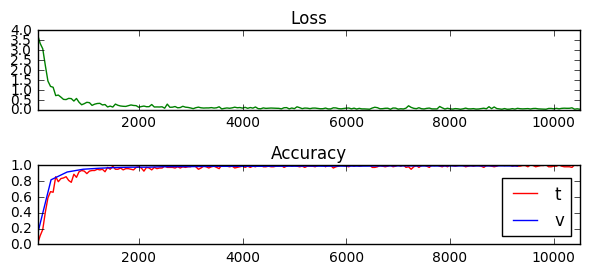

In [96]:
runGraph(tSignsGraph, plotResults=True, epochs=30, batchSize=128, trainInputs=X_train_shuffled, trainLabels=y_train_shuffled, test_dict=test_feed_dict, log_step=50)

In [52]:
# Validate our model with mnist dataset to check for input data problem
def mnistValidation():
    pickle_file = '../../DeepLearningCourse/notMNIST.pickle'

    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        mnist_train_dataset = save['train_dataset']
        mnist_train_labels = save['train_labels']
        mnist_test_dataset = save['test_dataset']
        mnist_test_labels = save['test_labels']
        del save  # hint to help gc free up memory
        print('Training set', mnist_train_dataset.shape, mnist_train_labels.shape)
        print('Test set', mnist_test_dataset.shape, mnist_test_labels.shape)

    mnist_image_size = 28
    mnist_num_labels = 10

    def reformat(dataset, labels):
        dataset = dataset.reshape((-1, mnist_image_size * mnist_image_size)).astype(np.float32)
        # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
        labels = (np.arange(mnist_num_labels) == labels[:,None]).astype(np.float32)
        return dataset, labels
    mnist_train_dataset, mnist_train_labels = reformat(mnist_train_dataset, mnist_train_labels)
    mnist_test_dataset, mnist_test_labels = reformat(mnist_test_dataset, mnist_test_labels)
    print('Training set', mnist_train_dataset.shape, mnist_train_labels.shape)
    print('Test set', mnist_test_dataset.shape, mnist_test_labels.shape)
    
    
    dict_mnist_test = {gInputs:mnist_test_dataset, gLabels:mnist_test_labels}

In [53]:
# Critical validation of the model using mnist data set
#runGraph(tSignsGraph, plotResults=True, epochs=3, batchSize=150, trainInputs=mnist_train_dataset, trainLabels=mnist_train_labels, test_dict=dict_mnist_test, log_step=50)

## Log

## Simple one-layer (no hidden) classifier

##### bsize=150, expDecay=0.5;1000, epochs=60
TrainAcc = 79.8%, TAcc = 45.1%

#### bsize=50
TrainAcc=93.6%, TAcc=59.6%

### Batch (sequencial vs random)
epochs=30, bsize=250

In: rnd: Train=99.44%, testAcc=49.35% <== first signs of bug

In: sequence: Train=86.88%, testAcc=86.19% 


## 1-Conv, 1L-Classifier
epochs 3, bsize=250

trainAcc=99.72%, testAcc= 49.81% <== that is what bug caused but I have not realized yet

with dropout: epochs=10, bsize=250: TrainAcc=94.92%, TestAcc=52.74%


## 2-Conv, MaxPool, 1L-Classifier
(not recorded all test results - stuck with nasty bug and )

==== END: of LOG


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Batch size=128 (random batch selection)

Epochs=30

stdev = math.sqrt(1e-3) for initial data initialization

L2C = 5e-5 //L2 reg constant

Parameters for Exponential decay:

DECAY_START = 0.1, 
DECAY_RATE = 0.95, 
DECAY_STEPS = 300 (decay every epoch)



### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I was taking a step by step approach starting with simple classifier and adding layers, while measuring performance.

As the last step I had to make a jump and add convolutions similar to what I did in mnist lab work.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.